# Optimization Final Project - Fair Candidate Selection

## Nidhish Nerur & Sandra You

## Part 1: Read in cleaned datasets

In [1]:
using DataFrames, CSV, Dates
using JuMP, Gurobi
using LinearAlgebra, Random, Printf, StatsBase, CategoricalArrays
using Plots, StatsPlots, Colors
using Distributions
using Random, Statistics

In [2]:
#Read in the cleaned candidate dataset
df_emp = CSV.read("clean_emp.csv", DataFrame)

#Read in the cleaned job dataset
df_job = CSV.read("clean_jobs.csv", DataFrame)

#Print first 5 rows of the employee dataset
first(df_emp, 5)

Row,YearsWorked,TitleMapped,EducationMapped,EmployeeStatusMapped,EmployeeTypeMapped,PayZoneMapped,DepartmentMapped,Age,GenderMapped,RaceMapped,PerformanceScoreMapped,PythonCode,JavaScriptCode,SocialMediaSkill,CADSoftwareSkill,NetworkDesign
,Float64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,5.21644,0,0,0,1,51788.2,0,55,0,2,63,0,0,0,1,0
2,1.81918,0,0,0,1,1.5003e5,0,59,1,4,52,0,0,0,1,0
3,5.99452,2,0,0,0,83611.1,2,33,1,4,52,0,0,1,0,0
4,3.46301,2,0,0,1,168592.0,2,26,1,3,56,0,0,1,0,0
5,5.44384,2,0,0,1,1.80363e5,2,55,0,3,67,0,0,1,0,0


In [3]:
#3000 potential candidates with 20 columns
size(df_emp)

(3000, 16)

In [4]:
#Over 170000 job listings with 11 criteria
size(df_job)

(173836, 11)

In [5]:
#Print first 5 rows of the jobs dataset
first(df_job, 5)

Row,Min_Exp,Max_Exp,QualificationMapped,Min_Salary,Max_Salary,WorkMapped,PythonCode,JavaScriptCode,SocialMediaSkill,CADSoftwareSkill,NetworkDesign
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,5,15,1,59000,99000,2,0,0,1,0,0
2,4,11,2,65000,91000,0,0,0,0,0,1
3,4,12,1,59000,93000,0,1,1,0,0,0
4,2,8,1,65000,102000,1,0,1,0,0,0
5,2,9,0,65000,102000,2,0,1,0,0,0


## Part 2: Baseline Model Predictions & Outcomes

## Performance Baseline Model

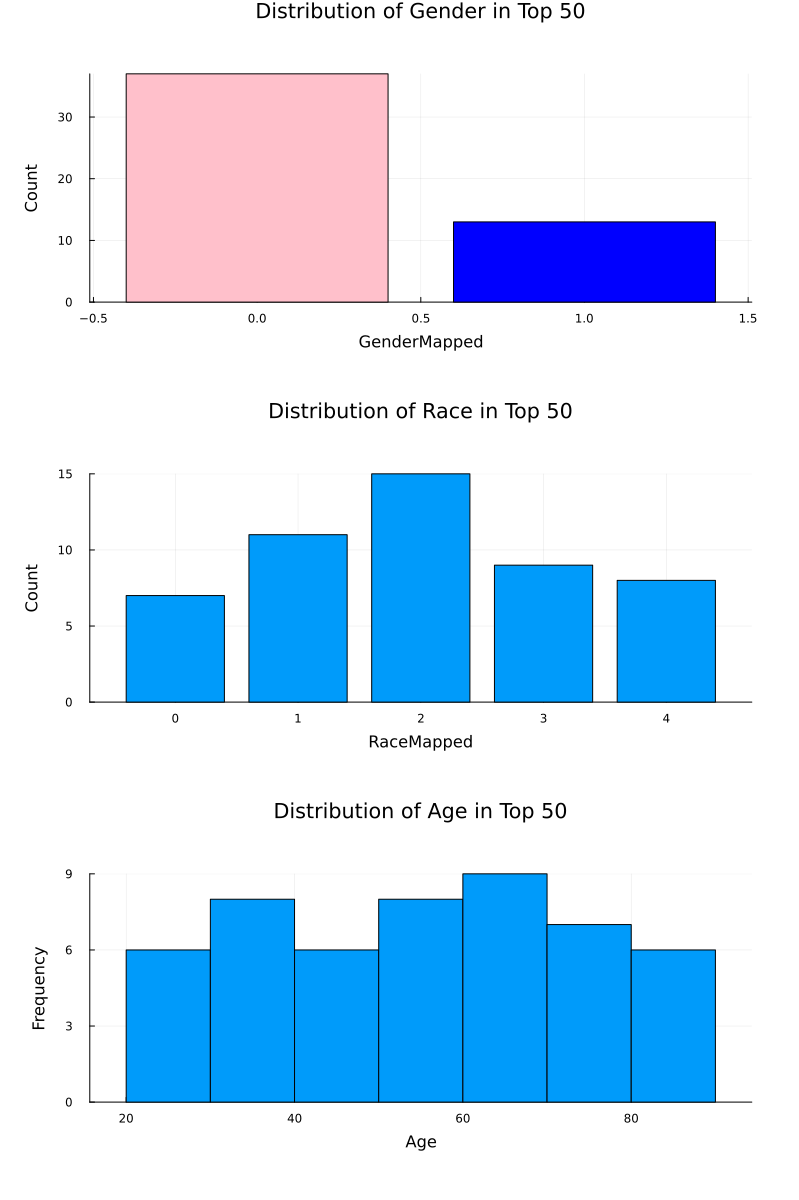

In [6]:
#Sort df_emp by PerformanceScoreMapped and keep the top 50
df_emp_sorted = sort(df_emp, :PerformanceScoreMapped, rev=true)
df_emp_top50 = first(df_emp_sorted, 50)

#Define a function to create a categorical distribution plot with optional color coding
function gender_distribution(df::DataFrame, column::Symbol, title::String)
    counts = combine(groupby(df, column), nrow => :count)
    labels = counts[:, column]
    values = counts[:, :count]
    
    #Assign colors based on gender
    #Female = 0, Male = 1
    gender_map = Dict(0 => colorant"pink", 1 => colorant"blue") 
    colors = [gender_map[label] for label in labels]

    bar(labels, values, 
        color=colors, 
        legend=false, 
        title=title, 
        xlabel=string(column), 
        ylabel="Count", 
        margin=10Plots.mm, 
        xticks=:all)
end

#Create gender plot with color coding
plot_gender = gender_distribution(df_emp_top50, :GenderMapped, "Distribution of Gender in Top 50")

#Create other plots without color coding
function categorical_distribution(df::DataFrame, column::Symbol, title::String)
    counts = combine(groupby(df, column), nrow => :count)
    bar(counts[:, column], counts[:, :count],
        legend=false, 
        title=title, 
        xlabel=string(column), 
        ylabel="Count", 
        margin=10Plots.mm)
end

plot_race = categorical_distribution(df_emp_top50, :RaceMapped, "Distribution of Race in Top 50")
plot_age = histogram(df_emp_top50.Age, 
                     bins=10, 
                     title="Distribution of Age in Top 50", 
                     xlabel="Age", 
                     ylabel="Frequency", 
                     legend=false, 
                     margin=10Plots.mm)

#Combine all plots into a single layout
plot(plot_gender, plot_race, plot_age, layout=(3, 1), size=(800, 1200))

In [7]:
# Count occurrences of each value in the GenderMapped column
gender_counts = combine(groupby(df_emp, :GenderMapped), nrow => :Count)

# Display the counts
println(gender_counts)

2×2 DataFrame
 Row │ GenderMapped  Count
     │ Int64         Int64
─────┼─────────────────────
   1 │            0   1682
   2 │            1   1318


In [8]:
# Count occurrences of each value in the GenderMapped column
gender_counts = combine(groupby(df_emp, :RaceMapped), nrow => :Count)

# Display the counts
println(gender_counts)

5×2 DataFrame
 Row │ RaceMapped  Count
     │ Int64       Int64
─────┼───────────────────
   1 │          0    629
   2 │          1    618
   3 │          2    599
   4 │          3    582
   5 │          4    572


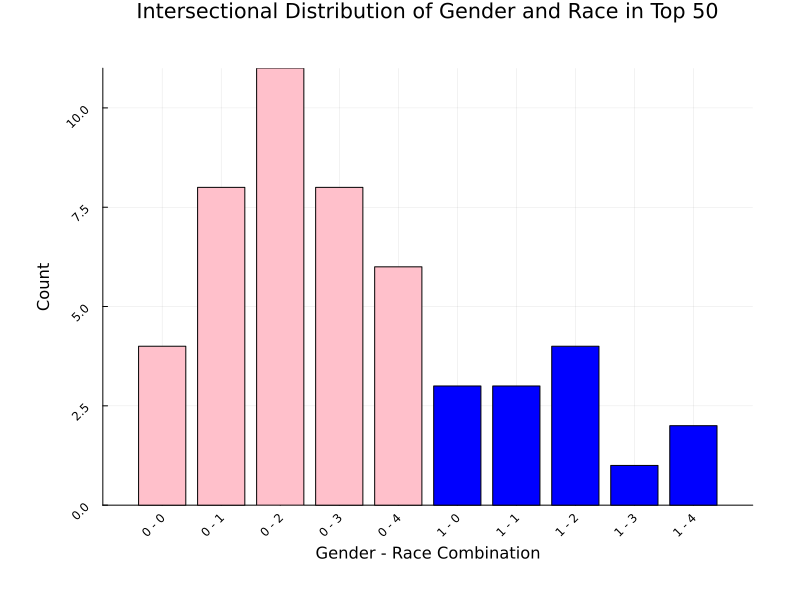

In [9]:
#Create a new column for the intersection of Gender and Race
df_emp_top50[!, :GenderRace] = string.(df_emp_top50.GenderMapped) .* " - " .* string.(df_emp_top50.RaceMapped)

#Define a function to create the intersectional distribution plot with reordering
function intersectional_distribution_reordered(df::DataFrame, column::Symbol, gender_column::Symbol, race_column::Symbol, title::String)
    counts = combine(groupby(df, column), nrow => :count)
    labels = counts[:, column]
    values = counts[:, :count]

    #Extract Gender and Race from the intersectional column
    gender_race_split = [split(label, " - ") for label in labels]
    genders = [parse(Int, x[1]) for x in gender_race_split]
    races = [parse(Int, x[2]) for x in gender_race_split]

    #Assign colors based on gender
    gender_map = Dict(0 => colorant"pink", 1 => colorant"blue") # Female = 0, Male = 1
    colors = [gender_map[g] for g in genders]

    #Create a DataFrame for sorting by Gender first and Race second
    plot_data = DataFrame(Label=labels, Count=values, Color=colors, Gender=genders, Race=races)
    plot_data = sort(plot_data, [:Gender, :Race]) #Sort by Gender, then by Race within Gender

    #Plot the reordered bar chart
    bar(plot_data.Label, plot_data.Count, 
        color=plot_data.Color, 
        legend=false, 
        title=title, 
        xlabel="Gender - Race Combination", 
        ylabel="Count", 
        margin=10Plots.mm, 
        xticks=:all, 
        rotation=45)
end

#Create the intersectional plot with reordering by Gender and Race
plot_intersectional_reordered = intersectional_distribution_reordered(
    df_emp_top50, 
    :GenderRace, 
    :GenderMapped, 
    :RaceMapped, 
    "Intersectional Distribution of Gender and Race in Top 50"
)

# Display the plot
plot(plot_intersectional_reordered, size=(800, 600))


In [10]:
#Calculate the average of PerformanceScoreMapped for the best performance candidates
average_performance_score = mean(df_emp_top50.PerformanceScoreMapped)

#Perfect 100 performance score for top 50 candidates 
println("Average Performance Score for top 50 candidates by performance: ", average_performance_score)

Average Performance Score for top 50 candidates by performance: 97.46


## Fairness Metric Formulation

**The fairness metric \( $F$ \) is defined as:**
$$
\begin{aligned}
    F = & \, 1 - w_1 D_r - w_2 D_g - w_3 D_{rg} - w_4 A
\end{aligned}
$$

#### Components:
1. **Race Discrepancy Penalty \( $D_r$ \)**:
    $$
    \begin{aligned}
        D_r = & \sum_{r} \left| p_r - q_r \right|
    \end{aligned}
    $$
    where \( $p_r$ \) is the proportion of race \( $r$ \) in the overall population, and \( $q_r$ \) is the proportion of race \( $r$ \) in the selected group.

2. **Gender Discrepancy Penalty \( $D_g$ \)**:
    $$
    \begin{aligned}
        D_g = & \sum_{g} \left| p_g - q_g \right|
    \end{aligned}
    $$
    where \( $p_g$ \) is the proportion of gender \( $g$ \) in the overall population, and \( $q_g$ \) is the proportion of gender \( $g$ \) in the selected group.

3. **Intersectional Discrepancy Penalty \( $D_{rg}$ \)**:
    $$
    \begin{aligned}
        D_{rg} = & \sum_{g} \sum_{r} \left| p_{rg} - q_{rg} \right|
    \end{aligned}
    $$
    where \( $p_{rg}$ \) is the proportion of individuals in the $(r, g)$ combination in the overall population, and \( $q_{rg}$ \) is the proportion in the selected group.

4. **Age Discrepancy Penalty \( $A$ \)**:
    $$
    \begin{aligned}
        A = & \frac{\left| \mu_{\text{age}}^{\text{overall}} - \mu_{\text{age}}^{\text{selected}} \right|}{\sigma_{\text{age}}^{\text{overall}}}
    \end{aligned}
    $$

#### Weights:
The weights \( $w_1$, $w_2$, $w_3$, $w_4$ \) are non-negative and satisfy:
$$
\begin{aligned}
    w_1 + w_2 + w_3 + w_4 = 1
\end{aligned}
$$



**The Fairness Metric \( $F$ \) is defined as:**
$$
\begin{aligned}
    F = & \, 1 - w_1 D_r - w_2 D_g - w_3 D_{rg} - w_4 A
\end{aligned}
$$

1. **Race Discrepancy Penalty \( $D_r$ \)**:
    $$
    \begin{aligned}
        D_r = & \sum_{r} \left| p_r - q_r \right|
    \end{aligned}
    $$
    
2. **Gender Discrepancy Penalty \( $D_g$ \)**:
$$
\begin{aligned}
    D_g = & \sum_{g} \left| p_g - q_g \right|
\end{aligned}
$$

3. **Intersectional Discrepancy Penalty \( $D_{rg}$ \)**:
$$
\begin{aligned}
    D_{rg} = & \sum_{g} \sum_{r} \left| p_{rg} - q_{rg} \right|
\end{aligned}
$$

4. **Age Discrepancy Penalty \( $A$ \)**:
$$
\begin{aligned}
    A = & \frac{\left| \mu_{\text{age}}^{\text{overall}} - \mu_{\text{age}}^{\text{selected}} \right|}{\sigma_{\text{age}}^{\text{overall}}}
\end{aligned}
$$

In [11]:
#Function to calculate proportions for a given column
function calculate_proportions(df::DataFrame, column::Symbol)
    total = nrow(df)
    counts = combine(groupby(df, column), nrow => :count)
    counts[!, :proportion] .= counts[!, :count] ./ total
    return counts
end

#Function to calculate demographic parity penalty
function demographic_parity_penalty(overall_props, selected_props)
    # Align proportions by matching categories
    merged = outerjoin(overall_props, selected_props, on=names(overall_props)[1], makeunique=true)
    merged[!, :proportion] .= coalesce.(merged[!, :proportion], 0.0)  # Overall proportion
    merged[!, :proportion_1] .= coalesce.(merged[!, :proportion_1], 0.0)  # Selected proportion
    penalty = sum(abs.(merged[!, :proportion] .- merged[!, :proportion_1]))
    return penalty
end

#Function to calculate intersectional parity penalty (double summation)
function intersectional_parity_penalty(overall_df::DataFrame, selected_df::DataFrame, race_col::Symbol, gender_col::Symbol)
    # Create intersectional column
    overall_df[!, :GenderRace] = string.(overall_df[!, gender_col]) .* " - " .* string.(overall_df[!, race_col])
    selected_df[!, :GenderRace] = string.(selected_df[!, gender_col]) .* " - " .* string.(selected_df[!, race_col])

    # Calculate proportions for each race-gender combination
    overall_props = calculate_proportions(overall_df, :GenderRace)
    selected_props = calculate_proportions(selected_df, :GenderRace)

    # Align proportions by matching categories
    merged = outerjoin(overall_props, selected_props, on=:GenderRace, makeunique=true)
    merged[!, :proportion] .= coalesce.(merged[!, :proportion], 0.0)  # Overall proportion
    merged[!, :proportion_1] .= coalesce.(merged[!, :proportion_1], 0.0)  # Selected proportion

    # Compute penalty as the sum of absolute differences across all race-gender combinations
    penalty = sum(abs.(merged[!, :proportion] .- merged[!, :proportion_1]))
    return penalty
end

#Function to calculate age parity penalty
function age_parity_penalty(overall_df::DataFrame, selected_df::DataFrame)
    mu_overall = mean(overall_df.Age)
    sigma_overall = std(overall_df.Age)
    mu_selected = mean(selected_df.Age)
    penalty = abs(mu_overall - mu_selected) / sigma_overall
    return penalty
end

age_parity_penalty (generic function with 1 method)

In [12]:
#Function to calculate the final fairness score
function fairness_metric(overall_df::DataFrame, selected_df::DataFrame, weights::Tuple{Float64, Float64, Float64, Float64})
    # Extract weights
    w1, w2, w3, w4 = weights

    #Demographic parity penalties
    race_penalty = demographic_parity_penalty(
        calculate_proportions(overall_df, :RaceMapped),
        calculate_proportions(selected_df, :RaceMapped)
    )
    gender_penalty = demographic_parity_penalty(
        calculate_proportions(overall_df, :GenderMapped),
        calculate_proportions(selected_df, :GenderMapped)
    )
    
    #Intersectional parity penalty (double summation across race and gender)
    intersection_penalty = intersectional_parity_penalty(
        overall_df, selected_df, :RaceMapped, :GenderMapped
    )

    #Age parity penalty
    age_penalty = age_parity_penalty(overall_df, selected_df)

    #Final fairness score
    fairness_score = 1.0 - w1 * race_penalty - w2 * gender_penalty - w3 * intersection_penalty - w4 * age_penalty
    
    return fairness_score, race_penalty, gender_penalty, intersection_penalty, age_penalty
end

#Weights for fairness metric, write in Float 
#w1 is for race, w2 is for gender, w3 is intersection, w4 is age
weights = (0.25, 0.25, 0.25, 0.25)

#Calculate fairness score for baseline model
fairness_score = fairness_metric(df_emp, df_emp_top50, weights)

println("Fairness Score for the Baseline Model: ", fairness_score)

Fairness Score for the Baseline Model: (0.7155542755999331, 0.22866666666666668, 0.3586666666666667, 0.42933333333333334, 0.1211162309336007)


## Optimal Fairness Model

In [13]:
#Set seed for reproducibility
Random.seed!(42)

function select_fair_candidates(df_emp::DataFrame, num_candidates::Int)
    #Calculate total number of candidates for each gender
    num_female = round(Int, num_candidates * 0.5)  #50% Female
    num_male = num_candidates - num_female         #50% Male

    #Calculate racial group proportions
    race_counts = combine(groupby(df_emp, :RaceMapped), nrow => :count)
    race_counts[!, :proportion] = race_counts[!, :count] ./ nrow(df_emp)

    #Select candidates by gender and race
    selected_candidates = DataFrame()

    #Select females
    df_female = filter(row -> row.GenderMapped == 0, df_emp)  # GenderMapped 0 = Female
    for (race, proportion) in zip(race_counts[!, :RaceMapped], race_counts[!, :proportion])
        num_race = round(Int, num_female * proportion)  # Proportional count for this race
        df_race_female = filter(row -> row.RaceMapped == race, df_female)
        if nrow(df_race_female) > 0
            sampled_indices = randperm(nrow(df_race_female))[1:min(num_race, nrow(df_race_female))]
            selected_candidates = vcat(selected_candidates, df_race_female[sampled_indices, :])
        end
    end

    #Select males
    df_male = filter(row -> row.GenderMapped == 1, df_emp)  # GenderMapped 1 = Male
    for (race, proportion) in zip(race_counts[!, :RaceMapped], race_counts[!, :proportion])
        num_race = round(Int, num_male * proportion)  # Proportional count for this race
        df_race_male = filter(row -> row.RaceMapped == race, df_male)
        if nrow(df_race_male) > 0
            sampled_indices = randperm(nrow(df_race_male))[1:min(num_race, nrow(df_race_male))]
            selected_candidates = vcat(selected_candidates, df_race_male[sampled_indices, :])
        end
    end

    #Adjust for age 
    overall_avg_age = mean(df_emp.Age)
    selected_candidates = selected_candidates[sortperm(abs.(selected_candidates.Age .- overall_avg_age)), :]  # Sort by age closeness
    selected_candidates = first(selected_candidates, num_candidates)  #Ensure only `num_candidates` are selected

    return selected_candidates
end

#Select 50 candidates from df_emp
num_candidates = 50
df_fair_candidates = select_fair_candidates(df_emp, num_candidates)

#Display selected candidates
println("Selected Candidates:")

#Summary statistics for verification
println("Summary:")
println("Gender distribution:")
println(combine(groupby(df_fair_candidates, :GenderMapped), nrow => :count))
println("Race distribution:")
println(combine(groupby(df_fair_candidates, :RaceMapped), nrow => :count))
println("Average age:")
println(mean(df_fair_candidates.Age))


Selected Candidates:
Summary:
Gender distribution:
2×2 DataFrame
 Row │ GenderMapped  count
     │ Int64         Int64
─────┼─────────────────────
   1 │            0     25
   2 │            1     25
Race distribution:
5×2 DataFrame
 Row │ RaceMapped  count
     │ Int64       Int64
─────┼───────────────────
   1 │          0     10
   2 │          1     10
   3 │          2     10
   4 │          3     10
   5 │          4     10
Average age:
48.14


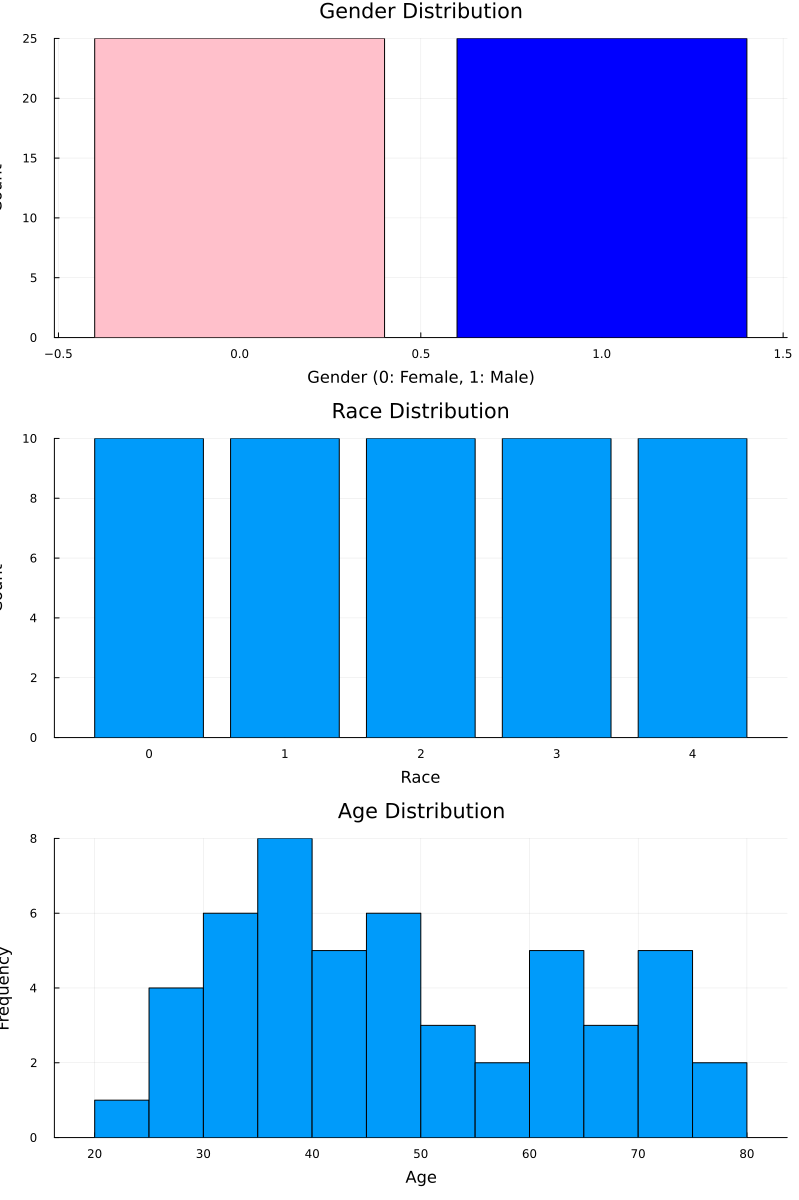

In [14]:
function create_fairness_plots(df::DataFrame)
    # Gender distribution
    gender_counts = combine(groupby(df, :GenderMapped), nrow => :count)
    gender_colors = [colorant"pink", colorant"blue"]  # Female: pink, Male: blue
    plot_gender = bar(gender_counts[:, :GenderMapped], gender_counts[:, :count],
                      color=gender_colors, legend=false, title="Gender Distribution",
                      xlabel="Gender (0: Female, 1: Male)", ylabel="Count")

    # Race distribution
    race_counts = combine(groupby(df, :RaceMapped), nrow => :count)
    plot_race = bar(race_counts[:, :RaceMapped], race_counts[:, :count],
                    legend=false, title="Race Distribution", xlabel="Race", ylabel="Count")

    # Age distribution
    plot_age = histogram(df.Age, bins=10, legend=false, title="Age Distribution",
                         xlabel="Age", ylabel="Frequency")

    # Combine plots
    return plot(plot_gender, plot_race, plot_age, layout=(3, 1), size=(800, 1200))
end

# Generate the plots
fairness_plots = create_fairness_plots(df_fair_candidates)
display(fairness_plots)

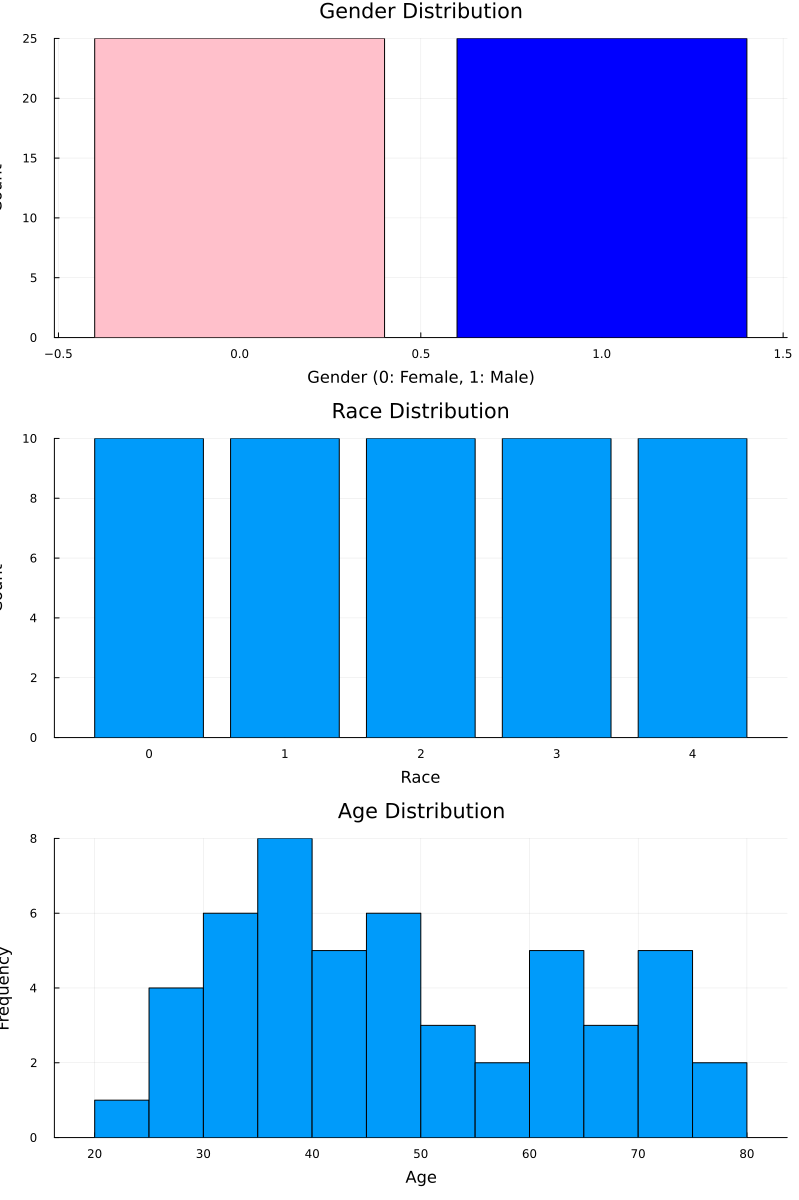

In [15]:
fairness_plots = create_fairness_plots(df_fair_candidates)
display(fairness_plots)

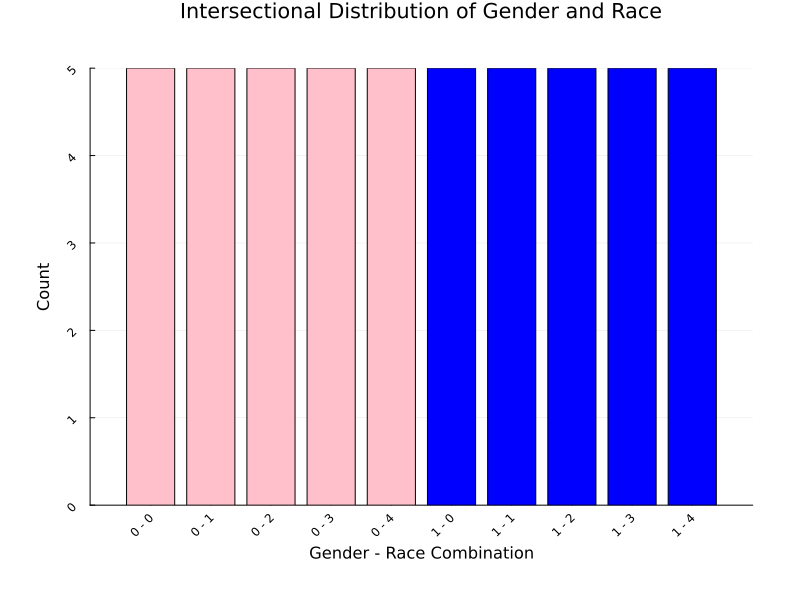

In [16]:
#Visualize intersectionality for perfect fairness
function intersectional_distribution_reordered(df::DataFrame, column::Symbol, title::String)
    # Compute counts for the intersectional column
    counts = combine(groupby(df, column), nrow => :count)
    labels = counts[:, column]
    values = counts[:, :count]

    # Extract Gender and Race from the intersectional column
    gender_race_split = [split(label, " - ") for label in labels]
    genders = [parse(Int, x[1]) for x in gender_race_split]
    races = [parse(Int, x[2]) for x in gender_race_split]

    # Assign colors based on gender
    gender_map = Dict(0 => colorant"pink", 1 => colorant"blue")  # Female = 0, Male = 1
    colors = [gender_map[g] for g in genders]

    # Create a DataFrame for sorting by Gender first and Race second
    plot_data = DataFrame(Label=labels, Count=values, Color=colors, Gender=genders, Race=races)
    plot_data = sort(plot_data, [:Gender, :Race])  # Sort by Gender, then by Race within Gender

    # Plot the reordered bar chart
    return bar(plot_data.Label, plot_data.Count,
               color=plot_data.Color,
               legend=false,
               title=title,
               xlabel="Gender - Race Combination",
               ylabel="Count",
               margin=10Plots.mm,
               xticks=:all,
               rotation=45)
end

# Create a new column for the intersection of Gender and Race
df_fair_candidates[!, :GenderRace] = string.(df_fair_candidates.GenderMapped) .* " - " .* string.(df_fair_candidates.RaceMapped)

# Create the intersectional plot with reordering by Gender and Race
plot_intersectional_reordered = intersectional_distribution_reordered(
    df_fair_candidates,
    :GenderRace,
    "Intersectional Distribution of Gender and Race"
)

# Display the plot
plot(plot_intersectional_reordered, size=(800, 600))


In [17]:
#Calculate the average of PerformanceScoreMapped for the fairness-selected candidates
average_performance_score = mean(df_fair_candidates.PerformanceScoreMapped)

#Lower performance average than just optimizing for performance alone 
println("Average Performance Score for fairness-selected candidates: ", average_performance_score)

Average Performance Score for fairness-selected candidates: 58.68


In [18]:
#Weights for fairness metric, write in Float 
#w1 is for race, w2 is for gender, w3 is intersection, w4 is age
weights = (0.25, 0.25, 0.25, 0.25)

#Calculate fairness score for baseline model
fairness_score = fairness_metric(df_emp, df_fair_candidates, weights)

println("Fairness Score for the Baseline Model: ", fairness_score)

Fairness Score for the Baseline Model: (0.8660271867294573, 0.031333333333333324, 0.1213333333333333, 0.12133333333333332, 0.26189125308217054)


## Part 3: Optimization Formulation


$$
\text{max} \quad \sum_{i=1}^{n} P_i \cdot x_i 
$$

$$
\text{s.t.}
$$

1. Experience Constraint:
$$
\text{min_exp} \leq \text{years_worked}_i \cdot x_i \leq \text{max_exp}, \quad \forall i \in \{1, \dots, n\}
$$

2. Education Match Constraint:
$$
\sum_{i=1}^{n} e_i \cdot x_i \geq 0.3 \cdot \sum_{i=1}^{n} x_i
$$

3. Employee Type Match Constraint:
$$
\sum_{i=1}^{n} \text{ETM}_i \cdot x_i \geq 0.3 \cdot \sum_{i=1}^{n} x_i
$$

4. Age Group Constraints:
$$
\sum_{i \in \{\text{Age}_i \in (22, 35]\}} x_i \geq \rho_1 \cdot \sum_{i=1}^n x_i
$$
$$
\sum_{i \in \{\text{Age}_i \in (35, 50]\}} x_i \geq \rho_2 \cdot \sum_{i=1}^n x_i
$$
$$
\sum_{i \in \{\text{Age}_i \in (50, 67]\}} x_i \geq \rho_3 \cdot \sum_{i=1}^n x_i
$$

$$
\text{Age}_i \cdot x_i \leq 67, \quad \forall i \in \{1, \dots, n\}
$$

5. Gender Constraint:
$$
\sum_{i=1}^{n} G_i \cdot x_i \geq \rho_4 \cdot \sum_{i=1}^{n} x_i
$$

6. Race Group Constraints:
$$
\sum_{i=1}^{n} R_{ki} \cdot x_i \geq \rho_5 \cdot \sum_{i=1}^{n} x_i, \quad \forall k \in \{0, 1, 2, 3, 4\}
$$

7. Python Skill Match Constraint:
$$
\sum_{i=1}^{n} (\text{Python}_i \cdot \text{Python}_{\text{job}}) \cdot x_i \geq 0.2 \cdot \sum_{i=1}^{n} x_i
$$

8. JavaScript Skill Match Constraint:
$$
\sum_{i=1}^{n} (\text{JavaScript}_i \cdot \text{JavaScript}_{\text{job}}) \cdot x_i \geq 0.2 \cdot \sum_{i=1}^{n} x_i
$$

9. Social Media Skill Match Constraint:
$$
\sum_{i=1}^{n} (\text{SocialMedia}_i \cdot \text{SocialMedia}_{\text{job}}) \cdot x_i \geq 0.2 \cdot \sum_{i=1}^{n} x_i
$$

10. CAD Software Skill Match Constraint:
$$
\sum_{i=1}^{n} (\text{CADSoftware}_i \cdot \text{CADSoftware}_{\text{job}}) \cdot x_i \geq 0.2 \cdot \sum_{i=1}^{n} x_i
$$

11. Network Design Skill Match Constraint:
$$
\sum_{i=1}^{n} (\text{NetworkDesign}_i \cdot \text{NetworkDesign}_{\text{job}}) \cdot x_i \geq 0.2 \cdot \sum_{i=1}^{n} x_i
$$

12. Subset Selection Constraint:
$$
\sum_{i=1}^{n} x_i = 50
$$


Objective Function:
- $P_i$ represents the performance score of candidate $i$.
- $x_i$ is a binary variable ($x_i \in \{0, 1\}^n$) indicating whether candidate $i$ is selected.
- $n$ is the total number of candidates.

Experience Constraint:
- $\text{years_worked}_i$ is the number of years candidate $i$ has worked.
- $\text{min_exp}$ and $\text{max_exp}$ are the minimum and maximum preferred years of experience.

Salary Constraint:
- $\text{PayZoneMapped}_i$ is the salary in current role for candidate $i$.
- $\text{min_salary}$ and $\text{max_salary}$ are the minimum and maximum allowed salary.

Education Match Constraint:
- $e_i$ is a binary indicator ($e_i \in \{0, 1\}^n$) that equals $1$ if candidate $i$'s education matches the job qualifications, and $0$ otherwise. We want at least 30% of candidates with the education matching the job preference.

Employee Type Match Constraint:
- $\text{ETM}_i$ is a binary indicator ($\text{ETM}_i \in \{0, 1\}^n$) that equals $1$ if candidate $i$'s work level status matches the job's preferred work level status, and $0$ otherwise. We want at least 50% of candidates' work level status to match the job preference.

Age Group Constraint:
- $\text{Age}_i$ is the age of candidate $i$.
- $\rho_1$ is the weight guaranteeing at least a specified proportion of candidates selected from the first age range of 22 to 35.
- $\rho_2$ is the weight guaranteeing at least a specified proportion of candidates selected from the second age range of 35 to 50.
- $\rho_3$ is the weight guaranteeing at least a specified proportion of candidates selected from the third age range of 50 to 67.

Gender Constraint:
- $G_i$ is the gender indicator for candidate $i$ ($G_i = 0$ for female, $G_i = 1$ for male).
- $\rho_4$ is the weight controlling the minimum proportion of male candidates.

Race Group Constraint:
- $R_{ki}$ is a binary indicator ($R_{ki} \in \{0, 1\}^n$) that equals $1$ if candidate $i$ belongs to race group $k$, and $0$ otherwise.
- $\rho_5$ is the weight ensuring a minimum proportion of candidates from each racial group.

Python Skill Match Constraint:
- $\text{Python}_i$ is a binary indicator ($\text{Python}_i \in \{0, 1\}^n$) that equals $1$ if candidate $i$ has Python skills, and $0$ otherwise.
- $\text{Python}_{\text{job}}$ is a constant (0 or 1) indicating whether Python is required for the job. We want at least 20% candidates to know Python if the job seeks Python skills.

JavaScript Skill Match Constraint:
- $\text{JavaScript}_i$ is a binary indicator ($\text{JavaScript}_i \in \{0, 1\}^n$) that equals $1$ if candidate $i$ has JavaScript skills, and $0$ otherwise.
- $\text{JavaScript}_{\text{job}}$ is a constant (0 or 1) indicating whether JavaScript is required for the job. We want at least 20% candidates to know JavaScript if the job seeks JavaScript skills.

Social Media Skill Match Constraint:
- $\text{SocialMedia}_i$ is a binary indicator ($\text{SocialMedia}_i \in \{0, 1\}^n$) that equals $1$ if candidate $i$ has social media skills, and $0$ otherwise.
- $\text{SocialMedia}_{\text{job}}$ is a constant (0 or 1) indicating whether social media skills are required for the job. We want at least 20% candidates to have Social Media skill if the job seeks Social Media skills.

CAD Software Skill Match Constraint:
- $\text{CADSoftware}_i$ is a binary indicator ($\text{CADSoftware}_i \in \{0, 1\}^n$) that equals $1$ if candidate $i$ has CAD software skills, and $0$ otherwise.
- $\text{CADSoftware}_{\text{job}}$ is a constant (0 or 1) indicating whether CAD software skills are required for the job. We want at least 20% candidates to know CAD if the job seeks CAD skills.

Network Design Skill Match Constraint:
- $\text{NetworkDesign}_i$ is a binary indicator ($\text{NetworkDesign}_i \in \{0, 1\}^n$) that equals $1$ if candidate $i$ has network design skills, and $0$ otherwise.
- $\text{NetworkDesign}_{\text{job}}$ is a constant (0 or 1) indicating whether network design skills are required for the job. We want at least 20% candidates to know Network Design if the job seeks Network Design  skills.



In [19]:
using JuMP, Gurobi

function optimize_candidate_selection(df_emp, df_job_num, weights, rho1, rho2, rho3, rho4, rho5)
    #Select job_num job 
    df_job_row = df_job[job_num:job_num, :]

    min_exp = df_job_row.Min_Exp[1]
    max_exp = df_job_row.Max_Exp[1]
    qualification_required = df_job_row.QualificationMapped[1]
    min_salary = df_job_row.Min_Salary[1]
    max_salary = df_job_row.Max_Salary[1]
    work_required = df_job_row.WorkMapped[1]
    python_required = df_job_row.PythonCode[1]
    javascript_required = df_job_row.JavaScriptCode[1]
    socialmedia_required = df_job_row.SocialMediaSkill[1]
    cad_required = df_job_row.CADSoftwareSkill[1]
    network_required = df_job_row.NetworkDesign[1]
    
    #Unpack the weights
    w1, w2, w3, w4 = weights

    # Create the model
    model = Model(Gurobi.Optimizer)

    # Number of candidates
    num_candidates = nrow(df_emp)

    # Decision variables: x[i] is 1 if candidate i is selected, 0 otherwise
    @variable(model, x[1:num_candidates], Bin)

    # Objective: Maximize performance score
    performance_scores = df_emp.PerformanceScoreMapped
    @objective(model, Max, sum(performance_scores[i] * x[i] for i in 1:num_candidates))

    # Constraints

    # 1. Total candidates selected = 50
    @constraint(model, sum(x[i] for i in 1:num_candidates) == 50)

    # 2. Experience constraint
    years_worked = df_emp.YearsWorked
    for i in 1:num_candidates
        @constraint(model, min_exp - 5 <= years_worked[i] * x[i])
        @constraint(model, years_worked[i] * x[i] <= max_exp + 5)
    end

    # 3. Education match constraint
    education_match = df_emp.EducationMapped .== qualification_required
    @constraint(model, sum(education_match[i] * x[i] for i in 1:num_candidates) <= 0.7 * sum(x[i] for i in 1:num_candidates))

    # 4. Employee type match constraint
    employee_type_match = df_emp.EmployeeTypeMapped .== work_required
    @constraint(model, sum(employee_type_match[i] * x[i] for i in 1:num_candidates) >= 0.3 * sum(x[i] for i in 1:num_candidates))

    # 5. Age group constraints
    age = df_emp.Age
    @constraint(model, sum(x[i] for i in 1:num_candidates if 22 <= age[i] < 35) >= rho1 * sum(x[i] for i in 1:num_candidates))
    @constraint(model, sum(x[i] for i in 1:num_candidates if 35 <= age[i] < 50) >= rho2 * sum(x[i] for i in 1:num_candidates))
    @constraint(model, sum(x[i] for i in 1:num_candidates if 50 <= age[i] <= 80) >= rho3 * sum(x[i] for i in 1:num_candidates))
    @constraint(model, [i=1:num_candidates], age[i] * x[i] <= 80)

    # 6. Gender constraint
    gender = df_emp.GenderMapped
    @constraint(model, sum(gender[i] * x[i] for i in 1:num_candidates) >= rho4 * sum(x[i] for i in 1:num_candidates))

    # 7. Race group constraints
    race = df_emp.RaceMapped
    for k in 0:4  # Assuming 5 race groups: 0, 1, 2, 3, 4
        @constraint(model, sum(x[i] for i in 1:num_candidates if race[i] == k) >= rho5 * sum(x[i] for i in 1:num_candidates))
    end

    # 8. Python code constraint
    python_required = df_job_row.PythonCode[1]
    @constraint(
        model,
        python_required * sum(df_emp.PythonCode[i] * x[i] for i in 1:num_candidates) 
        >= python_required * 0.2 * sum(x[i] for i in 1:num_candidates)
    )

    # 9. JavaScript code constraint
    javascript_required = df_job_row.JavaScriptCode[1]
    @constraint(
        model,
        javascript_required * sum(df_emp.JavaScriptCode[i] * x[i] for i in 1:num_candidates) 
        >= javascript_required * 0.2 * sum(x[i] for i in 1:num_candidates)
    )

    # 10. Social Media constraint
    socialmedia_required = df_job_row.SocialMediaSkill[1]
    @constraint(
        model,
        socialmedia_required * sum(df_emp.SocialMediaSkill[i] * x[i] for i in 1:num_candidates) 
        >= socialmedia_required * 0.2 * sum(x[i] for i in 1:num_candidates)
    )

    # 11. CAD constraint
    cad_required = df_job_row.CADSoftwareSkill[1]
    @constraint(
        model,
        cad_required * sum(df_emp.CADSoftwareSkill[i] * x[i] for i in 1:num_candidates) 
        >= cad_required * 0.2 * sum(x[i] for i in 1:num_candidates)
    )

    # 12. Network Design skill constraint
    network_required = df_job_row.NetworkDesign[1]
    @constraint(
        model,
        network_required * sum(df_emp.NetworkDesign[i] * x[i] for i in 1:num_candidates) 
        >= network_required * 0.2 * sum(x[i] for i in 1:num_candidates)
    )

    # Solve the optimization model
    optimize!(model)

    # Get the objective value (performance score)
    performance_score = JuMP.objective_value(model)

    # Get the selected candidates
    selected_candidates = JuMP.value.(x)

    # Filter df_emp for the selected candidates
    selected_indices = findall(x -> x == 1, selected_candidates)
    selected_df_emp = df_emp[selected_indices, :]

    
    # Calculate fairness scores
    fairness_score, race_penalty, gender_penalty, intersection_penalty, age_penalty = fairness_metric(df_emp, selected_df_emp, weights)

    return performance_score, fairness_score, selected_df_emp, race_penalty, gender_penalty, intersection_penalty, age_penalty
end
   

optimize_candidate_selection (generic function with 1 method)

# Gender Tradeoffs

In [20]:
function analyze_gender_weight_tradeoff_with_details(
    df_emp,
    job_num,
    weights,
    rho4_min,
    rho4_max,
    step,
    fixed_rho_values
)
    # Initialize storage for scores and penalties
    performance_scores = []
    fairness_scores = []
    age_penalties = []
    race_penalties = []
    gender_penalties = []
    intersection_penalties = []

    highest_perf_model = nothing  # To store the best performance model
    highest_fair_model = nothing  # To store the best fairness model
    highest_perf_score = -Inf    # Initial value for max performance score
    highest_fair_score = -Inf    # Initial value for max fairness score

    for rho4 in rho4_min:step:rho4_max
        try
            # Unpack fixed rho values
            age_1_weight, age_2_weight, age_3_weight, race_weight = fixed_rho_values

            # Run the optimization formulation
            perf_score, fair_score, selected_df_emp, age_penalty, race_penalty, gender_penalty, intersection_penalty = optimize_candidate_selection(
                df_emp,
                job_num,
                weights,
                age_1_weight,
                age_2_weight,
                age_3_weight,
                rho4,
                race_weight
            )

            # Only store results if optimization is successful
            if perf_score !== nothing && fair_score !== nothing
                push!(performance_scores, perf_score)
                push!(fairness_scores, fair_score)
                push!(age_penalties, age_penalty)
                push!(race_penalties, race_penalty)
                push!(gender_penalties, gender_penalty)
                push!(intersection_penalties, intersection_penalty)

                # Check if this is the highest performance model
                if perf_score > highest_perf_score
                    highest_perf_score = perf_score
                    highest_perf_model = selected_df_emp
                end

                # Check if this is the highest fairness model
                if fair_score > highest_fair_score
                    highest_fair_score = fair_score
                    highest_fair_model = selected_df_emp
                end
            end
        catch e
            println("Optimization failed for rho4=$rho4. Error: $e")
        end
    end

    return performance_scores, fairness_scores, age_penalties, race_penalties, gender_penalties, intersection_penalties, highest_perf_model, highest_fair_model
end


analyze_gender_weight_tradeoff_with_details (generic function with 1 method)

In [21]:
# Parameters
job_num = 2
rho4_min = 0.1
rho4_max = 1.0
step = 0.02
fixed_rho = 0.05
fixed_rho_values = (fixed_rho, fixed_rho, fixed_rho, fixed_rho)
weights = (0.25, 0.25, 0.25, 0.25)

# Run analysis
performance_scores, fairness_scores, age_penalties, race_penalties, gender_penalties, intersection_penalties, highest_perf_model, highest_fair_model = analyze_gender_weight_tradeoff_with_details(
    df_emp,
    job_num,
    weights,
    rho4_min,
    rho4_max,
    step,
    fixed_rho_values
)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 9017 rows, 3000 columns and 47988 nonzeros
Model fingerprint: 0xe3073ad4
Variable types: 0 continuous, 3000 integer (3000 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 2701.0000000
Presolve removed 9005 rows and 1413 columns
Presolve time: 0.02s
Presolved: 12 rows, 1587 columns, 6269 nonzeros
Variable types: 0 continuous, 1587 integer (939 binary)
Found heuristic solution: objective 4087.0000000

Root relaxation: objective 4.754000e+03, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bou

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 9017 rows, 3000 columns and 47988 nonzeros
Model fingerprint: 0x7ecb4d89
Variable types: 0 continuous, 3000 integer (3000 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 2701.0000000
Presolve removed 9005 rows and 1413 columns
Presolve time: 0.02s
Presolved: 12 rows, 1587 columns, 6269 nonzeros
Variable types: 0 continuous, 1587 integer (939 binary)
Found heuristic solution: objective 4133.0000000

Root relaxation: objective 4.754000e+03, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bou

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 9017 rows, 3000 columns and 47988 nonzeros
Model fingerprint: 0x0efe70ef
Variable types: 0 continuous, 3000 integer (3000 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 2701.0000000
Presolve removed 9005 rows and 1413 columns
Presolve time: 0.02s
Presolved: 12 rows, 1587 columns, 6269 nonzeros
Variable types: 0 continuous, 1587 integer (939 binary)
Found heuristic solution: objective 4069.0000000

Root relaxation: objective 4.754000e+03, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bou

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 9017 rows, 3000 columns and 47988 nonzeros
Model fingerprint: 0x6499445a
Variable types: 0 continuous, 3000 integer (3000 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 2701.0000000
Presolve removed 9005 rows and 1413 columns
Presolve time: 0.02s
Presolved: 12 rows, 1587 columns, 6269 nonzeros
Variable types: 0 continuous, 1587 integer (939 binary)
Found heuristic solution: objective 4084.0000000

Root relaxation: objective 4.745000e+03, 5 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bou

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 9017 rows, 3000 columns and 47988 nonzeros
Model fingerprint: 0xbfc6d5c6
Variable types: 0 continuous, 3000 integer (3000 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 2701.0000000
Presolve removed 9005 rows and 1413 columns
Presolve time: 0.02s
Presolved: 12 rows, 1587 columns, 6378 nonzeros
Variable types: 0 continuous, 1587 integer (939 binary)
Found heuristic solution: objective 4083.0000000

Root relaxation: objective 4.723000e+03, 9 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bou

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 9017 rows, 3000 columns and 47988 nonzeros
Model fingerprint: 0x88f07962
Variable types: 0 continuous, 3000 integer (3000 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 2660.0000000
Presolve removed 9005 rows and 1413 columns
Presolve time: 0.02s
Presolved: 12 rows, 1587 columns, 6378 nonzeros
Variable types: 0 continuous, 1587 integer (939 binary)
Found heuristic solution: objective 4013.0000000

Root relaxation: objective 4.680000e+03, 8 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bou

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 9017 rows, 3000 columns and 47988 nonzeros
Model fingerprint: 0x4cc07102
Variable types: 0 continuous, 3000 integer (3000 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 2641.0000000
Presolve removed 9005 rows and 1453 columns
Presolve time: 0.02s
Presolved: 12 rows, 1547 columns, 6218 nonzeros
Variable types: 0 continuous, 1547 integer (920 binary)
Found heuristic solution: objective 3980.0000000

Root relaxation: objective 4.624000e+03, 10 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bo

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 9017 rows, 3000 columns and 47988 nonzeros
Model fingerprint: 0xfaac397a
Variable types: 0 continuous, 3000 integer (3000 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 2670.0000000
Presolve removed 9005 rows and 2075 columns
Presolve time: 0.02s
Presolved: 12 rows, 925 columns, 3483 nonzeros
Found heuristic solution: objective 4537.0000000
Variable types: 0 continuous, 925 integer (623 binary)

Root relaxation: cutoff, 8 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Wor

(Any[4754.0, 4754.0, 4754.0, 4754.0, 4754.0, 4754.0, 4754.0, 4754.0, 4754.0, 4754.0  …  4624.0, 4613.0, 4602.0, 4591.0, 4580.0, 4568.0, 4553.0, 4537.0, 4516.0, 4488.0], Any[0.7436040229820441, 0.7306653704012139, 0.7306653704012139, 0.7309294808636796, 0.7306653704012139, 0.7306653704012139, 0.7408741221387818, 0.7552987463626448, 0.7310424624223862, 0.7306653704012139  …  0.5398408314335459, 0.4777725764061368, 0.4737409593178387, 0.45967249114994135, 0.44515322880167263, 0.42713040607904024, 0.3861147041051354, 0.380519852840242, 0.36684795218227356, 0.341649668427309], Any[0.29266666666666674, 0.3326666666666668, 0.3326666666666668, 0.2926666666666667, 0.3326666666666668, 0.3326666666666668, 0.2926666666666667, 0.29266666666666674, 0.2926666666666667, 0.3326666666666668  …  0.2526666666666667, 0.33266666666666667, 0.2926666666666667, 0.2926666666666667, 0.2526666666666667, 0.25266666666666665, 0.2926666666666667, 0.29266666666666663, 0.2526666666666667, 0.2926666666666667], Any[0.23

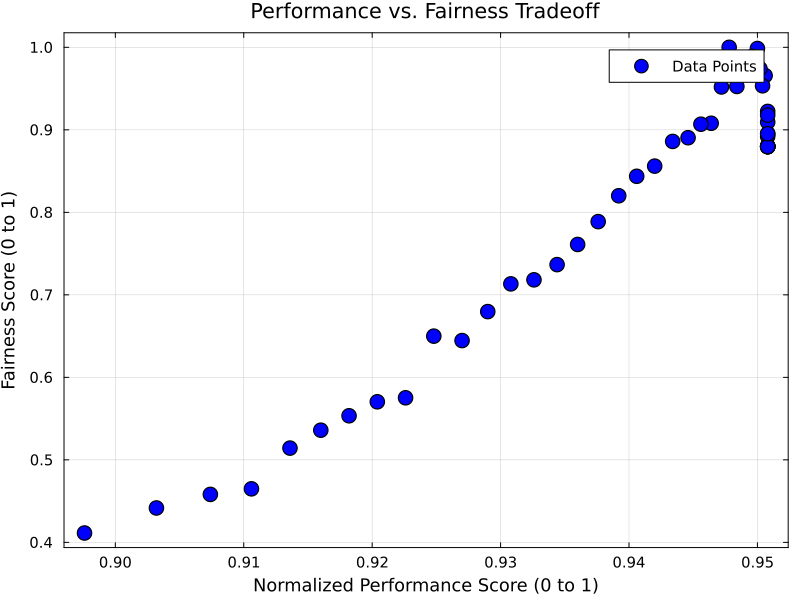

In [22]:
# Normalize performance scores (if needed)
normalized_performance_scores = performance_scores ./ 5000
normalized_fairness_scores = fairness_scores ./ maximum(fairness_scores)

# Create scatter plot
scatter(
    normalized_performance_scores, normalized_fairness_scores,
    xlabel="Normalized Performance Score (0 to 1)",
    ylabel="Fairness Score (0 to 1)",
    title="Performance vs. Fairness Tradeoff",
    label="Data Points",
    color=:blue,
    marker=:circle,
    markersize=8,
    legend=:topright,
    grid=true,
    framestyle=:box
)

# Add stylistic elements
plot!(
    size=(800, 600),  # Set the size of the plot
    legendfontsize=10,  # Adjust legend font size
    guidefontsize=12,  # Adjust axis label font size
    tickfontsize=10,  # Adjust tick font size
    titlefontsize=14,  # Adjust title font size
    linealpha=0.8  # Slight transparency for better visuals
)


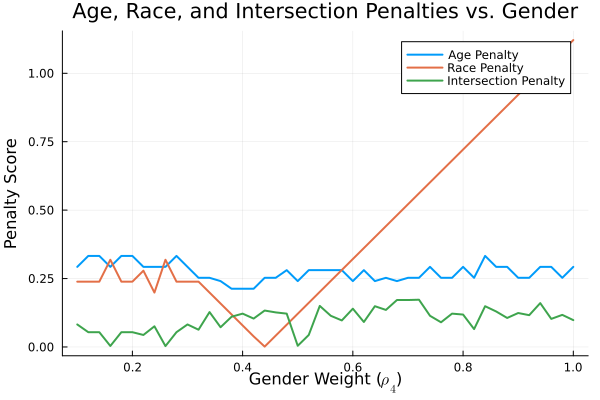

In [23]:
# Generate the range of rho4 values
rho4_values = range(rho4_min, stop=rho4_max, step=step)

# Plot age, race, and intersection penalties
plot(
    rho4_values,
    [age_penalties, race_penalties, intersection_penalties],
    label=["Age Penalty" "Race Penalty" "Intersection Penalty"],
    xlabel="Gender Weight (\$\\rho_4\$)",
    ylabel="Penalty Score",
    title="Age, Race, and Intersection Penalties vs. Gender",
    linewidth=2,
    legend=:topright,
    grid=true
)


# Race Weight Adjustment Tradeoffs

In [24]:
function analyze_race_weight_tradeoff_with_details(
    df_emp,
    job_num,
    weights,
    rho5_min,
    rho5_max,
    step,
    fixed_rho4,
    fixed_rho_values
)
    # Initialize storage for scores and penalties
    performance_scores = []
    fairness_scores = []
    age_penalties = []
    race_penalties = []
    gender_penalties = []
    intersection_penalties = []

    highest_perf_model = nothing  # To store the best performance model
    highest_fair_model = nothing  # To store the best fairness model
    highest_perf_score = -Inf    # Initial value for max performance score
    highest_fair_score = -Inf    # Initial value for max fairness score

    for rho5 in rho5_min:step:rho5_max
        try
            # Unpack fixed rho values
            age_1_weight, age_2_weight, age_3_weight = fixed_rho_values

            # Run the optimization formulation
            perf_score, fair_score, selected_df_emp, age_penalty, race_penalty, gender_penalty, intersection_penalty = optimize_candidate_selection(
                df_emp,
                job_num,
                weights,
                age_1_weight,
                age_2_weight,
                age_3_weight,
                fixed_rho4,
                rho5
            )

            # Only store results if optimization is successful
            if perf_score !== nothing && fair_score !== nothing
                push!(performance_scores, perf_score)
                push!(fairness_scores, fair_score)
                push!(age_penalties, age_penalty)
                push!(race_penalties, race_penalty)
                push!(gender_penalties, gender_penalty)
                push!(intersection_penalties, intersection_penalty)

                # Check if this is the highest performance model
                if perf_score > highest_perf_score
                    highest_perf_score = perf_score
                    highest_perf_model = selected_df_emp
                end

                # Check if this is the highest fairness model
                if fair_score > highest_fair_score
                    highest_fair_score = fair_score
                    highest_fair_model = selected_df_emp
                end
            end
        catch e
            println("Optimization failed for rho5=$rho5. Error: $e")
        end
    end

    return performance_scores, fairness_scores, age_penalties, race_penalties, gender_penalties, intersection_penalties, highest_perf_model, highest_fair_model
end


analyze_race_weight_tradeoff_with_details (generic function with 1 method)

In [25]:
# Parameters
job_num = 2
rho5_min = 0
rho5_max = 0.2
step = 0.01
fixed_rho4 = 0.05  # Fixed gender weight
fixed_rho_values = (0.05, 0.05, 0.05)  # Fixed age weights
weights = (0.25, 0.25, 0.25, 0.25)

# Run analysis
performance_scores, fairness_scores, age_penalties, race_penalties, gender_penalties, intersection_penalties, highest_perf_model, highest_fair_model = analyze_race_weight_tradeoff_with_details(
    df_emp,
    job_num,
    weights,
    rho5_min,
    rho5_max,
    step,
    fixed_rho4,
    fixed_rho_values
)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 9017 rows, 3000 columns and 35988 nonzeros
Model fingerprint: 0x43ec8d66
Variable types: 0 continuous, 3000 integer (3000 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 2701.0000000
Presolve removed 9010 rows and 2264 columns
Presolve time: 0.01s
Presolved: 7 rows, 736 columns, 2251 nonzeros
Variable types: 0 continuous, 736 integer (349 binary)
Found heuristic solution: objective 4464.0000000

Root relaxation: objective 4.754000e+03, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 9017 rows, 3000 columns and 47988 nonzeros
Model fingerprint: 0xbf9164df
Variable types: 0 continuous, 3000 integer (3000 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 2701.0000000
Presolve removed 9005 rows and 1413 columns
Presolve time: 0.02s
Presolved: 12 rows, 1587 columns, 6269 nonzeros
Variable types: 0 continuous, 1587 integer (939 binary)
Found heuristic solution: objective 4133.0000000

Root relaxation: objective 4.754000e+03, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bou

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 9017 rows, 3000 columns and 47988 nonzeros
Model fingerprint: 0x9d0d9bd1
Variable types: 0 continuous, 3000 integer (3000 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 2701.0000000
Presolve removed 9005 rows and 1413 columns
Presolve time: 0.02s
Presolved: 12 rows, 1587 columns, 6269 nonzeros
Variable types: 0 continuous, 1587 integer (939 binary)
Found heuristic solution: objective 4139.0000000

Root relaxation: objective 4.754000e+03, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bou

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 9017 rows, 3000 columns and 47988 nonzeros
Model fingerprint: 0x0efe469f
Variable types: 0 continuous, 3000 integer (3000 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+01]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+01]
Found heuristic solution: objective 2947.0000000
Presolve removed 9005 rows and 1413 columns
Presolve time: 0.02s
Presolved: 12 rows, 1587 columns, 6269 nonzeros
Variable types: 0 continuous, 1587 integer (939 binary)
Found heuristic solution: objective 4147.0000000

Root relaxation: objective 4.746000e+03, 15 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bo

(Any[4754.0, 4754.0, 4754.0, 4754.0, 4754.0, 4754.0, 4754.0, 4754.0, 4754.0, 4754.0  …  4754.0, 4754.0, 4754.0, 4754.0, 4753.0, 4753.0, 4751.0, 4751.0, 4746.0, 4746.0], Any[0.7224558639606758, 0.7310424624223862, 0.7309294808636796, 0.7306653704012139, 0.7306653704012139, 0.7554670866462494, 0.7552987463626448, 0.7309294808636796, 0.7309294808636796, 0.7408741221387818  …  0.7394618526549478, 0.7394618526549478, 0.7535303208228451, 0.7447338385691112, 0.7460724058937462, 0.7500267604484814, 0.779751427300442, 0.779751427300442, 0.8172304913352355, 0.8073988316188401], Any[0.29266666666666674, 0.2926666666666667, 0.2926666666666667, 0.3326666666666668, 0.3326666666666668, 0.29266666666666674, 0.29266666666666674, 0.2926666666666667, 0.2926666666666667, 0.2926666666666667  …  0.2926666666666667, 0.2926666666666667, 0.2526666666666667, 0.29266666666666674, 0.2526666666666667, 0.2526666666666667, 0.16066666666666674, 0.16066666666666674, 0.031333333333333324, 0.031333333333333324], Any[0.3

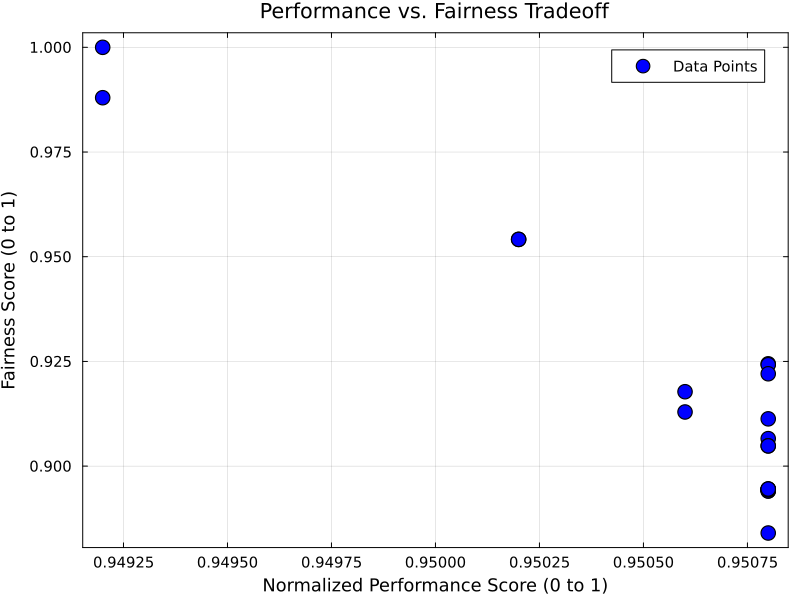

In [26]:
# Normalize performance scores (if needed)
normalized_performance_scores = performance_scores ./ 5000
normalized_fairness_scores = fairness_scores ./ maximum(fairness_scores)

# Create scatter plot
scatter(
    normalized_performance_scores, normalized_fairness_scores,
    xlabel="Normalized Performance Score (0 to 1)",
    ylabel="Fairness Score (0 to 1)",
    title="Performance vs. Fairness Tradeoff",
    label="Data Points",
    color=:blue,
    marker=:circle,
    markersize=8,
    legend=:topright,
    grid=true,
    framestyle=:box
)

# Add stylistic elements
plot!(
    size=(800, 600),  # Set the size of the plot
    legendfontsize=10,  # Adjust legend font size
    guidefontsize=12,  # Adjust axis label font size
    tickfontsize=10,  # Adjust tick font size
    titlefontsize=14,  # Adjust title font size
    linealpha=0.8  # Slight transparency for better visuals
)


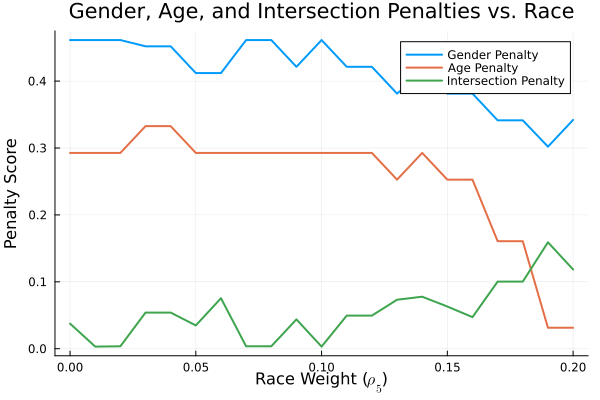

In [27]:
# Generate the range of rho5 values
rho5_values = range(rho5_min, stop=rho5_max, step=step)

# Plot gender, age, and intersection penalties
plot(
    rho5_values,
    [gender_penalties, age_penalties, intersection_penalties],
    label=["Gender Penalty" "Age Penalty" "Intersection Penalty"],
    xlabel="Race Weight (\$\\rho_5\$)",
    ylabel="Penalty Score",
    title="Gender, Age, and Intersection Penalties vs. Race",
    linewidth=2,
    legend=:topright,
    grid=true
)


# Run Model Performance/Fairness for 10 Job Postings

In [28]:
function optimize_candidate_selection(df_emp, df_job_num, weights, rho1, rho2, rho3, rho4, rho5)
    # Select df_job_num job 
    df_job_row = df_job[df_job_num:df_job_num, :]
    print("Selected job row: ", df_job_row)

    min_exp = df_job_row.Min_Exp[1]
    max_exp = df_job_row.Max_Exp[1]
    qualification_required = df_job_row.QualificationMapped[1]
    min_salary = df_job_row.Min_Salary[1]
    max_salary = df_job_row.Max_Salary[1]
    work_required = df_job_row.WorkMapped[1]
    python_required = df_job_row.PythonCode[1]
    javascript_required = df_job_row.JavaScriptCode[1]
    socialmedia_required = df_job_row.SocialMediaSkill[1]
    cad_required = df_job_row.CADSoftwareSkill[1]
    network_required = df_job_row.NetworkDesign[1]

    # Unpack the weights
    w1, w2, w3, w4 = weights

    # Create the model
    model = Model(Gurobi.Optimizer)

    # Number of candidates
    num_candidates = nrow(df_emp)

    # Decision variables: x[i] is 1 if candidate i is selected, 0 otherwise
    @variable(model, x[1:num_candidates], Bin)

    # Objective: Maximize performance score
    performance_scores = df_emp.PerformanceScoreMapped
    @objective(model, Max, sum(performance_scores[i] * x[i] for i in 1:num_candidates))

    # Constraints

    # 1. Total candidates selected = 50
    @constraint(model, sum(x[i] for i in 1:num_candidates) == 50)

    # 2. Experience constraint
    years_worked = df_emp.YearsWorked
    for i in 1:num_candidates
        @constraint(model, min_exp - 5 <= years_worked[i] * x[i])
        @constraint(model, years_worked[i] * x[i] <= max_exp + 5)
    end

    # 3. Education match constraint
    education_match = df_emp.EducationMapped .== qualification_required
    @constraint(model, sum(education_match[i] * x[i] for i in 1:num_candidates) <= 0.7 * sum(x[i] for i in 1:num_candidates))

    # 4. Employee type match constraint
    employee_type_match = df_emp.EmployeeTypeMapped .== work_required
    @constraint(model, sum(employee_type_match[i] * x[i] for i in 1:num_candidates) >= 0.3 * sum(x[i] for i in 1:num_candidates))

    # 5. Age group constraints
    age = df_emp.Age
    @constraint(model, sum(x[i] for i in 1:num_candidates if 22 <= age[i] < 35) >= rho1 * sum(x[i] for i in 1:num_candidates))
    @constraint(model, sum(x[i] for i in 1:num_candidates if 35 <= age[i] < 50) >= rho2 * sum(x[i] for i in 1:num_candidates))
    @constraint(model, sum(x[i] for i in 1:num_candidates if 50 <= age[i] <= 80) >= rho3 * sum(x[i] for i in 1:num_candidates))
    @constraint(model, [i=1:num_candidates], age[i] * x[i] <= 80)

    # 6. Gender constraint
    gender = df_emp.GenderMapped
    @constraint(model, sum(gender[i] * x[i] for i in 1:num_candidates) >= rho4 * sum(x[i] for i in 1:num_candidates))

    # 7. Race group constraints
    race = df_emp.RaceMapped
    for k in 0:4  # Assuming 5 race groups: 0, 1, 2, 3, 4
        @constraint(model, sum(x[i] for i in 1:num_candidates if race[i] == k) >= rho5 * sum(x[i] for i in 1:num_candidates))
    end

    # 8. Python code constraint
    python_required = df_job_row.PythonCode[1]
    @constraint(
        model,
        python_required * sum(df_emp.PythonCode[i] * x[i] for i in 1:num_candidates) 
        >= python_required * 0.2 * sum(x[i] for i in 1:num_candidates)
    )

    # 9. JavaScript code constraint
    javascript_required = df_job_row.JavaScriptCode[1]
    @constraint(
        model,
        javascript_required * sum(df_emp.JavaScriptCode[i] * x[i] for i in 1:num_candidates) 
        >= javascript_required * 0.2 * sum(x[i] for i in 1:num_candidates)
    )

    # 10. Social Media constraint
    socialmedia_required = df_job_row.SocialMediaSkill[1]
    @constraint(
        model,
        socialmedia_required * sum(df_emp.SocialMediaSkill[i] * x[i] for i in 1:num_candidates) 
        >= socialmedia_required * 0.2 * sum(x[i] for i in 1:num_candidates)
    )

    # 11. CAD constraint
    cad_required = df_job_row.CADSoftwareSkill[1]
    @constraint(
        model,
        cad_required * sum(df_emp.CADSoftwareSkill[i] * x[i] for i in 1:num_candidates) 
        >= cad_required * 0.2 * sum(x[i] for i in 1:num_candidates)
    )

    # 12. Network Design skill constraint
    network_required = df_job_row.NetworkDesign[1]
    @constraint(
        model,
        network_required * sum(df_emp.NetworkDesign[i] * x[i] for i in 1:num_candidates) 
        >= network_required * 0.2 * sum(x[i] for i in 1:num_candidates)
    )

    # Solve the optimization model
    optimize!(model)

    # Get the objective value (performance score)
    performance_score = JuMP.objective_value(model)

    # Get the selected candidates
    selected_candidates = JuMP.value.(x)

    # Filter df_emp for the selected candidates
    selected_indices = findall(x -> x == 1, selected_candidates)
    selected_df_emp = df_emp[selected_indices, :]

    # Calculate fairness scores
    fairness_score, _, _, _, _ = fairness_metric(df_emp, selected_df_emp, weights)

    return performance_score, fairness_score
end


optimize_candidate_selection (generic function with 1 method)

In [29]:
optimize_candidate_selection(df_emp, 826, (0.25, 0.25, 0.25, 0.25), 0.05, 0.05, 0.05, 0.05, 0.05)

Selected job row: 1×11 DataFrame
 Row │ Min_Exp  Max_Exp  QualificationMapped  Min_Salary  Max_Salary  WorkMapped  PythonCode  JavaScriptCode  SocialMediaSkill  CADSoftwareSkill  NetworkDesign
     │ Int64    Int64    Int64                Int64       Int64       Int64       Int64       Int64           Int64             Int64             Int64
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │       3        8                    2       57000       88000           0           0               0                 1                 0              0Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-21
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 9017 rows, 3000 columns and 47988

(4808.0, 0.8028136936335795)